# Twitter Sentiment Analysis using Part 1: **Glove Embeddings** and Part 2: **BERT model**

##### The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

##### Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

 

## Motivation

Hate  speech  is  an  unfortunately  common  occurrence  on  the  Internet.  Often social media sites like Facebook and Twitter face the problem of identifying and censoring  problematic  posts  while weighing the right to freedom of speech. The  importance  of  detecting  and  moderating hate  speech  is  evident  from  the  strong  connection between hate speech and actual hate crimes. Early identification of users promoting  hate  speech  could  enable  outreach  programs that attempt to prevent an escalation from speech to action. Sites such as Twitter and Facebook have been seeking  to  actively  combat  hate  speech. In spite of these reasons, NLP research on hate speech has been very limited, primarily due to the lack of a general definition of hate speech, an analysis of its demographic influences, and an investigation of the most effective features.

 

## Data

Our overall collection of tweets was split in the ratio of 65:35 into training and testing data. Out of the testing data, 30% is public and the rest is private.

 

### Data Files
 
- train.csv - For training the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line    storing a tweet id, its label and the tweet.

- test_tweets.csv - The test data file contains only tweet ids and the tweet text with each tweet in a new line.
 

### Submission Details

The following 2 files are to be uploaded:

1. test_predictions.csv - This should contain the 0/1 label for the tweets in test_tweets.csv, in the same order corresponding to the tweets in test_tweets.csv. Each 0/1 label should be in a new line.
 
2. A .zip file of source code - The code should produce the output file submitted and must be properly commented.
 

## Evaluation Metric:

The metric used for evaluating the performance of classification model would be F1-Score.
The metric can be understood as -

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

False Positives (FP) – When actual class is no and predicted class is yes.

False Negatives (FN) – When actual class is yes but predicted class in no.

Precision = TP/TP+FP

Recall = TP/TP+FN

### F1 Score = 2*(Recall * Precision) / (Recall + Precision)

- F1 is usually more useful than accuracy, especially if for an uneven class distribution.

# Import and load the dataset

In [4]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
import re
import string

# Reset the output dimensions
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import f1_score, accuracy_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

#from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset

from scipy import linalg

from collections import Counter

import pickle

import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

from gensim import matutils, models
from gensim.models import Word2Vec

import scipy.sparse

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

plt.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-darkgrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oguru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Detect hardware, return appropriate distribution strategy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS available: ", strategy.num_replicas_in_sync)

REPLICAS available:  1


In [7]:
train = pd.read_csv('/kaggle/input/twitter-sentiment-analysis/train.csv')
test = pd.read_csv('/kaggle/input/twitter-sentiment-analysis/test.csv')
submission = pd.read_csv('/kaggle/input/twitter-sentiment-analysis/sample_submission.csv')
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test.columns = test.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print('Train Data shape: ', train.shape, 'Test Data shape: ', test.shape)

train.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/twitter-sentiment-analysis/train.csv'

In [5]:
# word_count
train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['tweet'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['tweet'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['tweet'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['tweet'].apply(lambda x: len(str(x)))
test['char_count'] = test['tweet'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))

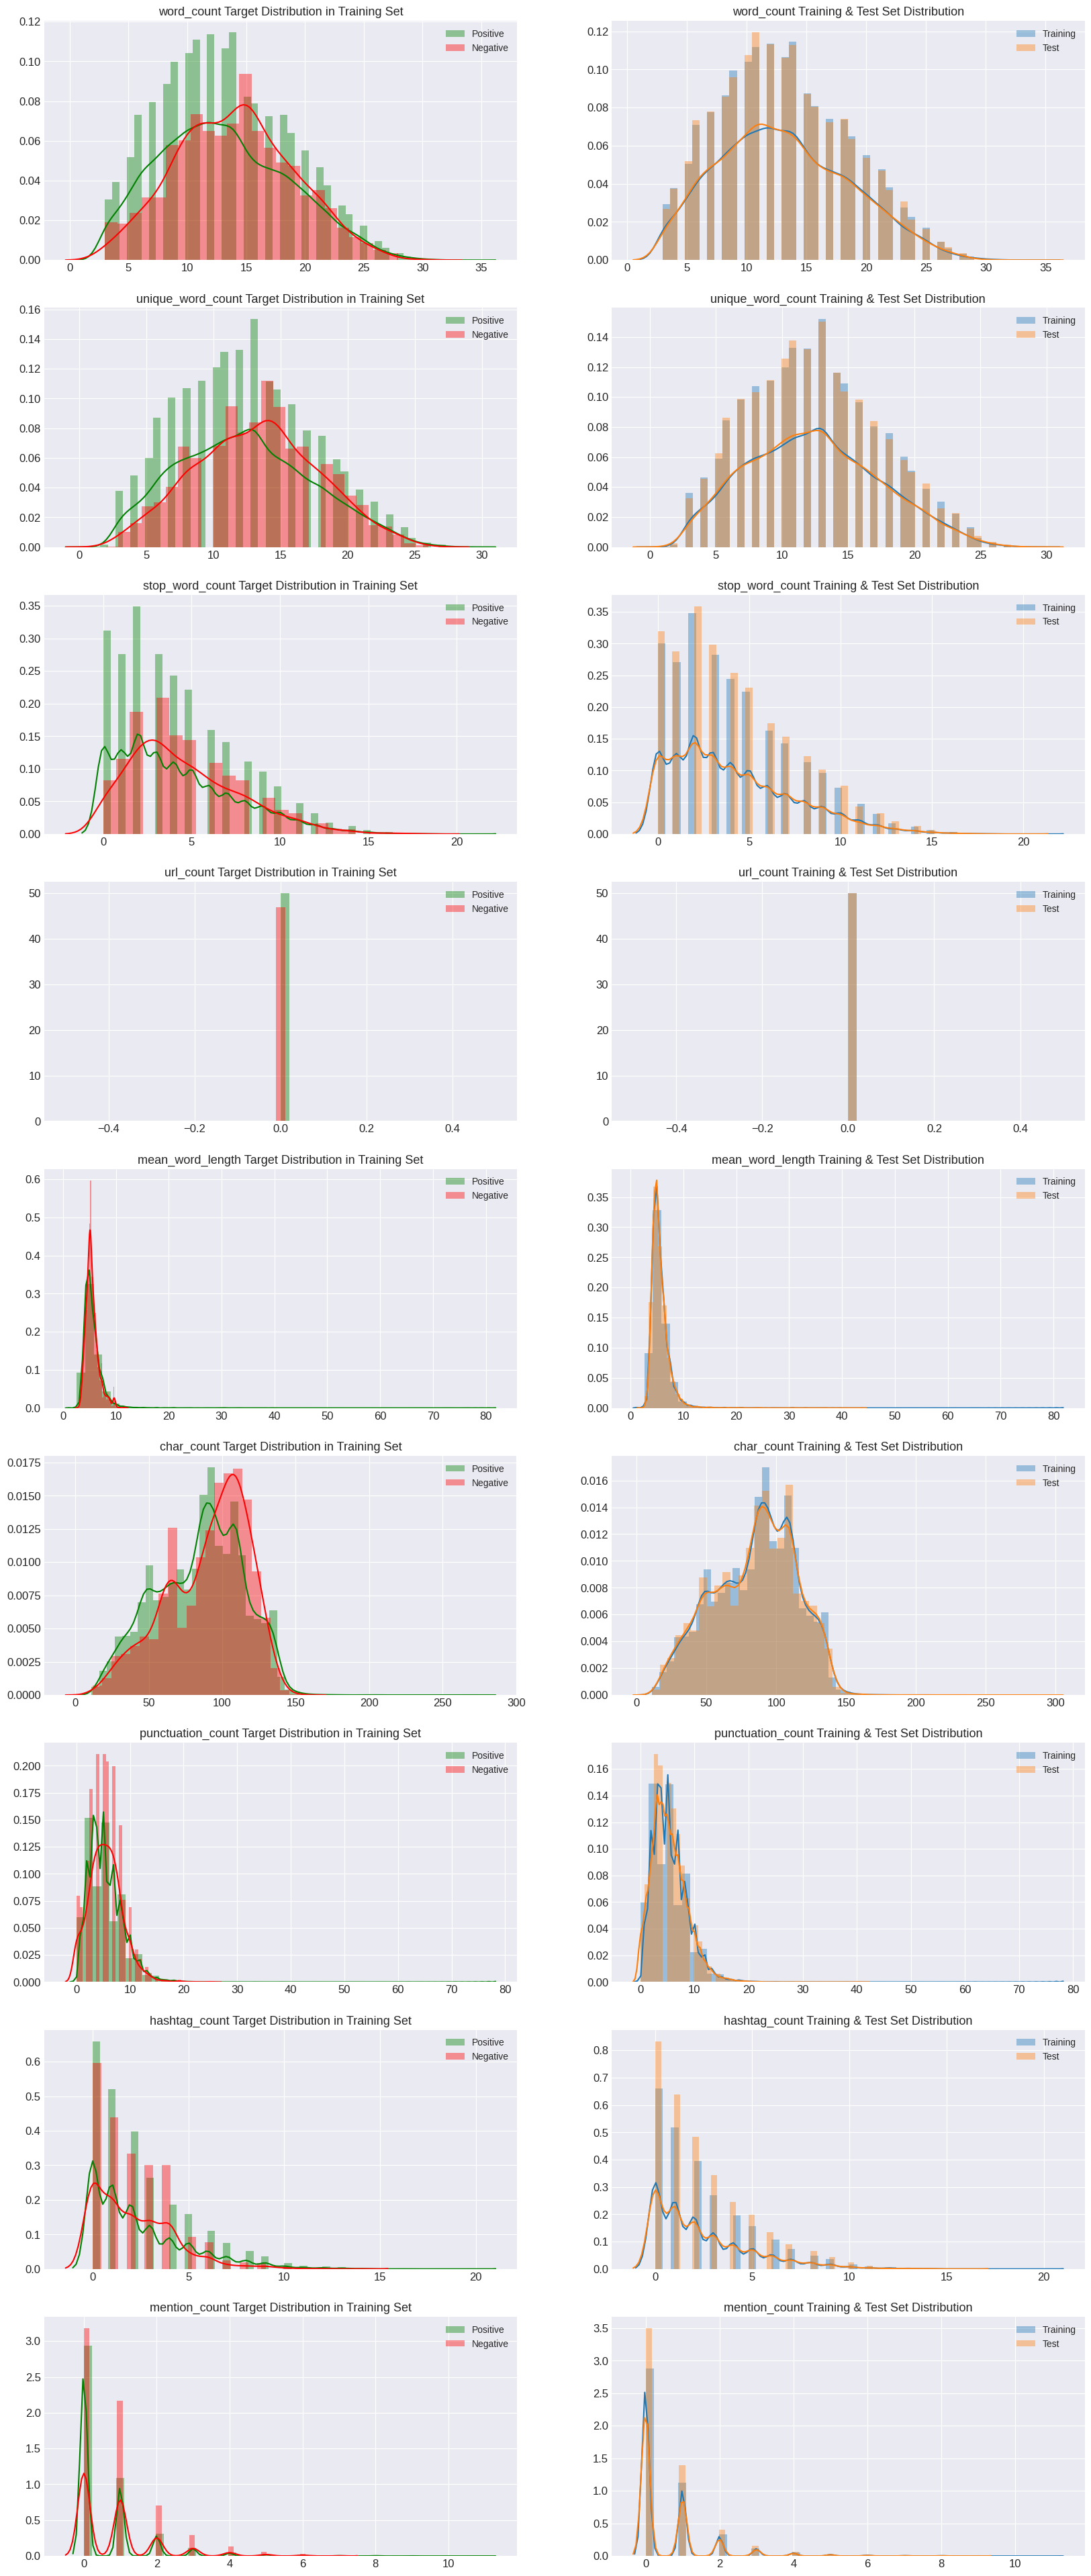

In [6]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
        'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

TWEETS = train['label'] == 1

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (20, 50), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~TWEETS][feature], label = 'Positive', ax = axes[i][0], color = 'green')
    sns.distplot(train.loc[TWEETS][feature], label = 'Negative', ax = axes[i][0], color = 'red')

    sns.distplot(train[feature], label = 'Training', ax = axes[i][1])
    sns.distplot(test[feature], label = 'Test', ax = axes[i][1])
  
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis = 'x', labelsize = 12)
        axes[i][j].tick_params(axis = 'y', labelsize = 12)
        axes[i][j].legend()
  
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize = 13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize = 13)

plt.show()

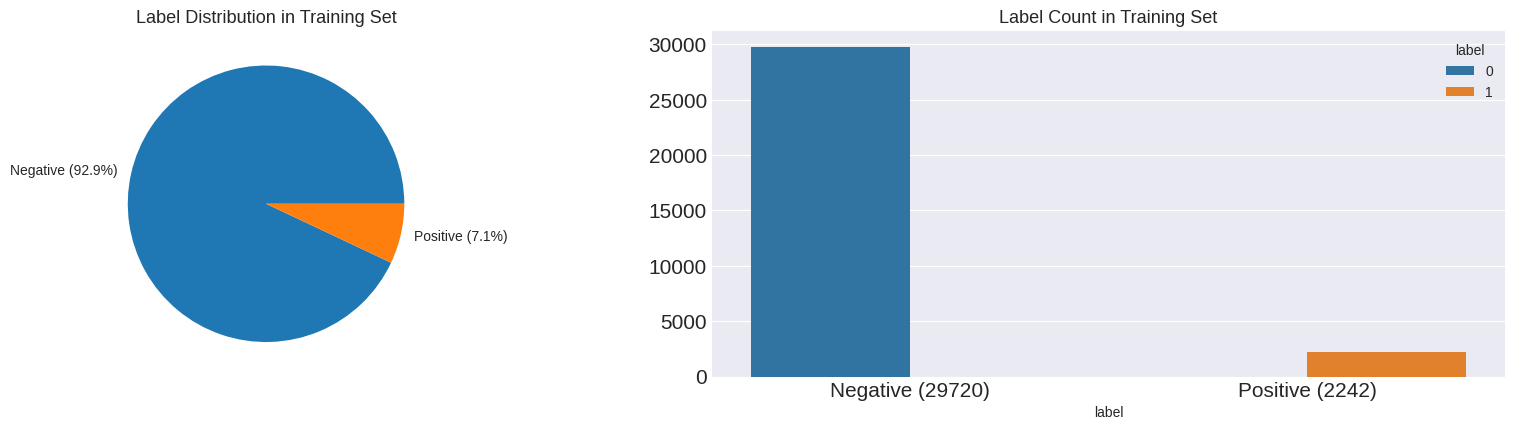

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (17, 4), dpi = 100)
plt.tight_layout()

train.groupby('label').count()['id'].plot(kind = 'pie', ax = axes[0], labels = ['Negative (92.9%)', 'Positive (7.1%)'])
sns.countplot(x = train['label'], hue = train['label'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Negative (29720)', 'Positive (2242)'])
axes[0].tick_params(axis = 'x', labelsize = 15)
axes[0].tick_params(axis = 'y', labelsize = 15)
axes[1].tick_params(axis = 'x', labelsize = 15)
axes[1].tick_params(axis = 'y', labelsize = 15)

axes[0].set_title('Label Distribution in Training Set', fontsize = 13)
axes[1].set_title('Label Count in Training Set', fontsize = 13)

plt.show()

# Data Preprocessing and Cleaning

In [8]:
def remove_stopwords(string):
    word_list = [word.lower() for word in string.split()]
    stopwords_list = list(stopwords.words("english"))
    for word in word_list:
        if word in stopwords_list:
            word_list.remove(word)
    return ' '.join(word_list)

In [9]:
train['tweet_length'] = train['tweet'].apply(len)
train['tweet'] = train['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'https\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'http\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
train['tweet'] = train['tweet'].str.lower()

train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
train['tweet'] = train['tweet'].apply(lambda x: remove_stopwords(x))

test['tweet'] = test['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
test['tweet'] = test['tweet'].str.lower()

test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
test['tweet'] = test['tweet'].apply(lambda x: remove_stopwords(x))

In [10]:
def clean_text(text):
    '''make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('user ', '', text)
    text = re.sub('amp ', '', text)
    text = re.sub('like ', '', text)
    text = re.sub('new ', '', text)
    text = re.sub('people ', '', text)
    text = re.sub('bihday', 'birthday', text)
    text = re.sub('allahsoil', 'allah soil', text)
    return text

In [11]:
train['tweet'] = train['tweet'].apply(lambda x: clean_text(x))
test['tweet'] = test['tweet'].apply(lambda x: clean_text(x))

In [12]:
train_data = train.copy()

label = {0: 'A', 1: 'B'}
train['label'] = train['label'].map(label)
train = train.drop('id', axis = 1)

train = pd.get_dummies(train, columns = ['label'])
train.head()

,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,tweet_length,label_A,label_B
0,father dysfunctional is selfish drags kids his...,18,16,10,0,4.555556,102,3,1,1,102,1,0
1,thanks lyft credit use cause don offer wheelch...,19,18,6,0,5.315789,122,8,3,2,122,1,0
2,birthday majesty,3,3,1,0,5.666667,21,0,0,0,21,1,0
3,model love take all time urð ð ð ð ð ð ð ð,14,13,5,0,4.928571,86,4,1,0,86,1,0
4,factsguide society motivation,4,4,0,0,8.000000,39,2,1,0,39,1,0


In [13]:
categories = ['label_A', 'label_B']

train_dict = {}

for column in categories:
    a = train.loc[train[column] == 1, 'tweet'].tolist()
    train_dict[column] = ' '.join(a)

In [14]:
# We can either keep it in dictionary format or put it into a pandas dataframe

data_df = pd.DataFrame(train_dict.items())
data_df.columns = ['index', 'tweet']
data_df = data_df.set_index('index')
data_df = data_df.sort_index()
data_df.head()

,tweet
index,
label_A,father dysfunctional is selfish drags kids his...
label_B,cnn calls michigan middle school build wall ch...


In [15]:
data_df = pd.DataFrame(data_df['tweet'].apply(lambda x: clean_text(x)))
data_clean = data_df.copy()
data_df.head()

,tweet
index,
label_A,father dysfunctional is selfish drags kids his...
label_B,cnn calls michigan middle school build wall ch...


# Exploratory Data Analysis

In [16]:
cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(data_df['tweet'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm = data_dtm.transpose()
data_dtm.head()

index,label_A,label_B
aa,2,0
aaa,3,0
aaaaa,1,0
aaaaaand,1,0
aaaaah,1,0


In [17]:
# Find the top 30 words on each category

top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending = False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'label_A': [('love', 2722),
  ('day', 2321),
  ('happy', 1674),
  ('life', 1123),
  ('time', 1115),
  ('today', 1065),
  ('thankful', 946),
  ('positive', 928),
  ('birthday', 846),
  ('good', 833),
  ('smile', 711),
  ('father', 631),
  ('want', 625),
  ('healthy', 602),
  ('weekend', 597),
  ('work', 595),
  ('fun', 587),
  ('summer', 576),
  ('make', 530),
  ('friday', 523),
  ('family', 519),
  ('got', 514),
  ('beautiful', 509),
  ('best', 508),
  ('bull', 503),
  ('friends', 500),
  ('way', 492),
  ('need', 486),
  ('great', 486),
  ('days', 486)],
 'label_B': [('trump', 207),
  ('libtard', 149),
  ('white', 139),
  ('black', 134),
  ('racist', 107),
  ('politics', 96),
  ('soil', 92),
  ('allah', 92),
  ('liberal', 82),
  ('women', 78),
  ('sjw', 74),
  ('obama', 72),
  ('hate', 71),
  ('racism', 65),
  ('retweet', 61),
  ('feel', 59),
  ('listen', 57),
  ('america', 54),
  ('stomping', 48),
  ('right', 47),
  ('race', 46),
  ('men', 46),
  ('woman', 43),
  ('comments', 39),
  

In [18]:
# Print the top 15 words said by each category

for category, top_words in top_dict.items():
    print(category + ":")
    print(', '.join([word for word, count in top_words[0:14]]))
    print('-----------------------------------------------------------------------------------------------------------------------')

label_A:
love, day, happy, life, time, today, thankful, positive, birthday, good, smile, father, want, healthy
-----------------------------------------------------------------------------------------------------------------------
label_B:
trump, libtard, white, black, racist, politics, soil, allah, liberal, women, sjw, obama, hate, racism
-----------------------------------------------------------------------------------------------------------------------


#### NOTE: At this point, we could go on and create word clouds. However, by looking at these top words, you can see that some of them have very little meaning and could be added to a stop words list, so let's figure that out

### Look at the most common top words add them to the stop word list

In [19]:
# Let's first pull out the top words for each category

words = []
for category in data_dtm.columns:
    top = [word for (word, count) in top_dict[category]]
    for t in top:
        words.append(t)
        
words

# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('love', 1),
 ('day', 1),
 ('happy', 1),
 ('life', 1),
 ('time', 1),
 ('today', 1),
 ('thankful', 1),
 ('positive', 1),
 ('birthday', 1),
 ('good', 1),
 ('smile', 1),
 ('father', 1),
 ('want', 1),
 ('healthy', 1),
 ('weekend', 1),
 ('work', 1),
 ('fun', 1),
 ('summer', 1),
 ('make', 1),
 ('friday', 1),
 ('family', 1),
 ('got', 1),
 ('beautiful', 1),
 ('best', 1),
 ('bull', 1),
 ('friends', 1),
 ('way', 1),
 ('need', 1),
 ('great', 1),
 ('days', 1),
 ('trump', 1),
 ('libtard', 1),
 ('white', 1),
 ('black', 1),
 ('racist', 1),
 ('politics', 1),
 ('soil', 1),
 ('allah', 1),
 ('liberal', 1),
 ('women', 1),
 ('sjw', 1),
 ('obama', 1),
 ('hate', 1),
 ('racism', 1),
 ('retweet', 1),
 ('feel', 1),
 ('listen', 1),
 ('america', 1),
 ('stomping', 1),
 ('right', 1),
 ('race', 1),
 ('men', 1),
 ('woman', 1),
 ('comments', 1),
 ('miamiâ', 1),
 ('stop', 1),
 ('video', 1),
 ('man', 1),
 ('sex', 1),
 ('blm', 1)]

In [20]:
data_dtm

index,label_A,label_B
aa,2,0
aaa,3,0
aaaaa,1,0
aaaaaand,1,0
aaaaah,1,0
...,...,...
ð¾ð½ðµð,1,0
ð¾ñ,2,0
ó¾,272,0
øª,1,0


In [21]:
# Find the bottom 200 words in each category

bottom_dict = {}
for c in data_dtm.columns:
    bottom = data_dtm[c].sort_values(ascending = True).head(200)
    bottom_dict[c]= list(zip(bottom.index, bottom.values))

# Let's first pull out the bottom words for each category

bottom_words = []
for category in data_dtm.columns:
    bottom = [word for (word, count) in bottom_dict[category]]
    for b in bottom:
        bottom_words.append(b)

Counter(bottom_words).most_common()

[('blazing', 1),
 ('eugenie', 1),
 ('imo', 1),
 ('nobdy', 1),
 ('hebrews', 1),
 ('nobelprize', 1),
 ('chriâ', 1),
 ('wso', 1),
 ('stillwithher', 1),
 ('christmassy', 1),
 ('christmaseve', 1),
 ('christmasadve', 1),
 ('jerusalem', 1),
 ('noborders', 1),
 ('ksa', 1),
 ('heed', 1),
 ('tefugeeswelcome', 1),
 ('noafd', 1),
 ('bikinis', 1),
 ('eugenics', 1),
 ('ethnocentrism', 1),
 ('chumps', 1),
 ('chump', 1),
 ('degrading', 1),
 ('billionaire', 1),
 ('impeachtrump', 1),
 ('kumbaya', 1),
 ('heededâ', 1),
 ('billing', 1),
 ('etre', 1),
 ('impacts', 1),
 ('bwahahahahaha', 1),
 ('bilal', 1),
 ('jerodtwin', 1),
 ('wtfâ', 1),
 ('asianmen', 1),
 ('jeremyjoseph', 1),
 ('impeachtrumpâ', 1),
 ('scale', 1),
 ('christiaâ', 1),
 ('parentage', 1),
 ('realitycheck', 1),
 ('fliers', 1),
 ('wahhhh', 1),
 ('kot', 1),
 ('marxism', 1),
 ('marxist', 1),
 ('evan', 1),
 ('assistants', 1),
 ('realiâ', 1),
 ('immanuelâ', 1),
 ('asslicker', 1),
 ('deltaairlines', 1),
 ('associated', 1),
 ('bigotâ', 1),
 ('stigmatiz

### Wordclouds for positive and negative tweets

In [22]:
# Let's make some word clouds!

stop_words = text.ENGLISH_STOP_WORDS

wc = WordCloud(stopwords = stop_words, background_color = "white", colormap = "Dark2", max_font_size = 150, random_state = 42)

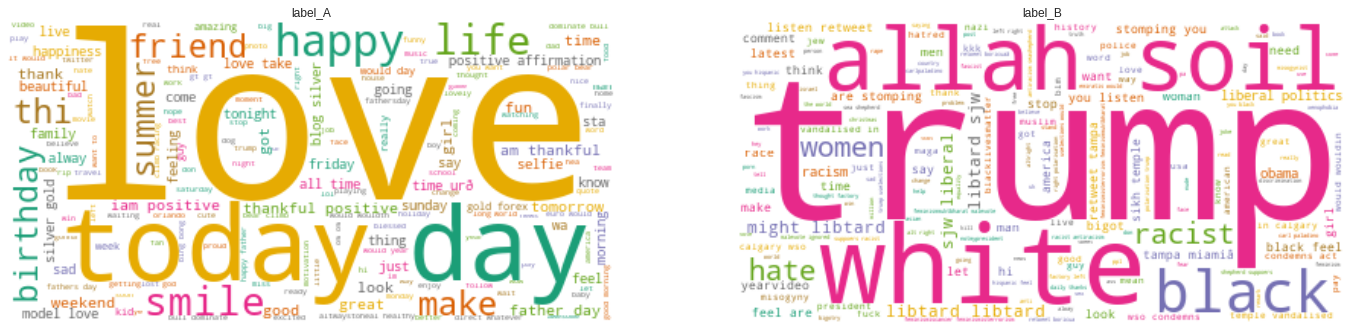

In [23]:
# Create subplots for each category

for index, description in enumerate(data_dtm.columns):
    wc.generate(data_clean.tweet[description])
    
    plt.subplot(1, 2, index + 1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(categories[index])
    
plt.show()

In [24]:
# Find the number of unique words that each category has

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for category in data_dtm.columns:
    uniques = data_dtm[category].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(categories, unique_list)), columns = ['category', 'unique_words'])
data_unique_sort = data_words.sort_values(by = 'unique_words')
data_unique_sort

,category,unique_words
1,label_B,5725
0,label_A,37701


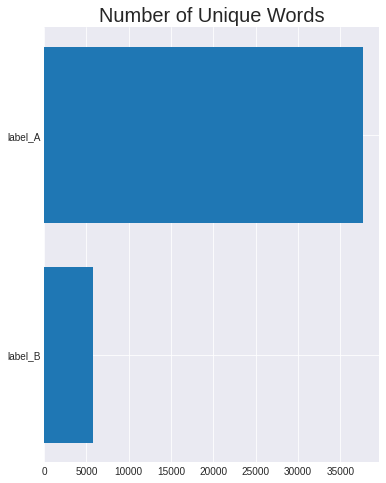

In [25]:
y_pos = np.arange(len(data_words))

plt.figure(figsize = (6, 8))
plt.barh(y_pos, data_unique_sort.unique_words, align = 'center')
plt.yticks(y_pos, data_unique_sort.category)
plt.title('Number of Unique Words', fontsize = 20)
plt.show()

# Model Building

In [26]:
Train, Test = train_test_split(train_data.drop('id', axis = 1), test_size = 0.25, random_state = 22) # Splits Dataset into Training and Testing set
print("Train Data size:", len(Train))
print("Test Data size", len(Test))

Train Data size: 23971
Test Data size 7991


In [27]:
Train.head()

,label,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,tweet_length
25619,0,share happiness friday ð friday makeitagoodone...,10,10,2,0,8.000000,93,11,4,0,93
2634,0,watch facebook page competition be posted afte...,14,14,4,0,5.785714,96,4,2,0,96
1931,0,find home away home kappa kappa gamma sign for...,21,19,5,0,4.523810,118,7,1,1,118
21536,0,being censored youtube war vegans truth,9,9,3,0,5.333333,59,4,1,0,59
8707,0,quotestags quote nofilter quotestagsapp,4,4,0,0,10.000000,47,4,3,0,47


## Keras Tokenizer

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

- **fit_on_texts** : Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 

##### So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

In [28]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Train.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 33586


# KERAS

### KERAS pad_sequences

###### This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
- Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.
- Sequences longer than num_timesteps are truncated so that they fit the desired length.

###### The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

In [29]:
MAX_LENGTH = 30

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(Train.tweet), maxlen = MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(Test.tweet),
                       maxlen = MAX_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (23971, 30)
Testing X Shape: (7991, 30)


In [30]:
# Get all the train labels

labels = Train.tweet.unique().tolist()

In [31]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Train.label.to_list())

y_train = encoder.transform(Train.label.to_list())
y_test = encoder.transform(Test.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (23971, 1)
y_test shape: (7991, 1)


# Fetch Glove embeddings

### What are word embeddings?

##### "Word embeddings" are a family of natural language processing techniques aiming at mapping semantic meaning into a geometric space. This is done by associating a numeric vector to every word in a dictionary, such that the distance (e.g. L2 distance or more commonly cosine distance) between any two vectors would capture part of the semantic relationship between the two associated words. The geometric space formed by these vectors is called an embedding space.

##### For instance, "coconut" and "polar bear" are words that are semantically quite different, so a reasonable embedding space would represent them as vectors that would be very far apart. But "kitchen" and "dinner" are related words, so they should be embedded close to each other.

In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-08-30 19:22:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-30 19:22:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-30 19:22:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [33]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
BATCH_SIZE = 1024
EPOCHS = 15
MODEL_PATH = '/kaggle/working/best_model.hdf5'

Next, we need to load the entire GloVe word embedding file into memory as a dictionary of word to embedding array.

In [34]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

The result is a matrix of weights only for words we will see during training.

In [35]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False)

In [37]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

- Bidirectional LSTM
##### The basic idea of bidirectional recurrent neural nets is to present each training sequence forwards and backwards to two separate recurrent nets, both of which are connected to the same output layer. … This means that for every point in a given sequence, the BRNN has complete, sequential information about all points before and after it. Also, because the net is free to use as much or as little of this context as necessary, there is no need to find a (task-dependent) time-window or target delay size.


- Dropout
##### It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.


- SpatialDropout1D
##### This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements

In [38]:
sequence_input = Input(shape = (MAX_LENGTH,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LR = 1e-3

model.compile(optimizer = Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [40]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [41]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_test, y_test), callbacks = [ReduceLROnPlateau])

Epoch 1/15
24/24 [==============================] - 4s 157ms/step - loss: 0.2977 - accuracy: 0.9112 - val_loss: 0.1929 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 2/15
24/24 [==============================] - 3s 133ms/step - loss: 0.1780 - accuracy: 0.9292 - val_loss: 0.1632 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 3/15
24/24 [==============================] - 3s 130ms/step - loss: 0.1569 - accuracy: 0.9390 - val_loss: 0.1523 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 4/15
24/24 [==============================] - 3s 133ms/step - loss: 0.1382 - accuracy: 0.9498 - val_loss: 0.1400 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 5/15
24/24 [==============================] - 3s 131ms/step - loss: 0.1222 - accuracy: 0.9555 - val_loss: 0.1312 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 6/15
24/24 [==============================] - 3s 132ms/step - loss: 0.1057 - accuracy: 0.9625 - val_loss: 0.1318 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 7/15
24/24 [==============================] - 3s 130ms/step - lo

## Model Performance

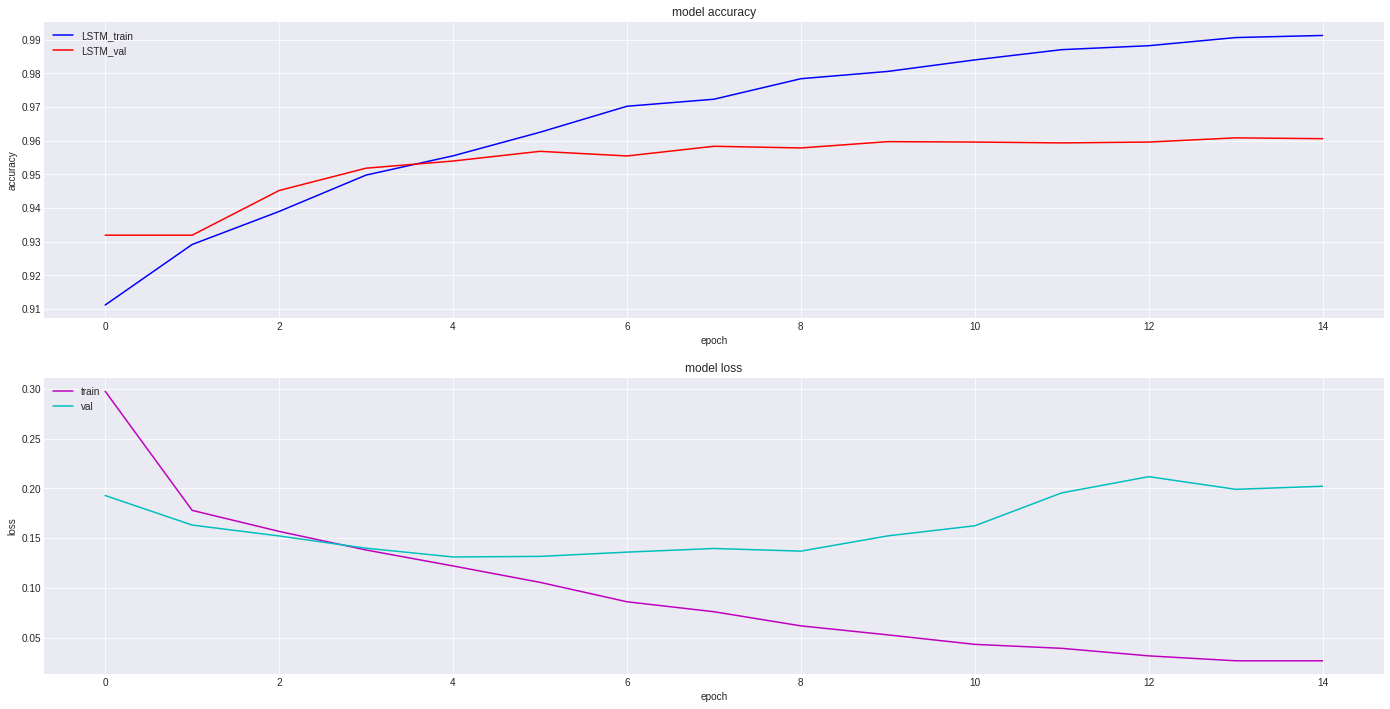

In [42]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c = 'b')
at.plot(history.history['val_accuracy'], c ='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc ='upper left')

al.plot(history.history['loss'], c ='m')
al.plot(history.history['val_loss'], c ='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [43]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = model.predict(X_test, verbose = 1, batch_size = 10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 2ms/step


# Classification Matrix

In [44]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 13)
    plt.yticks(tick_marks, classes, fontsize = 13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 17)
    plt.xlabel('Predicted label', fontsize = 17)

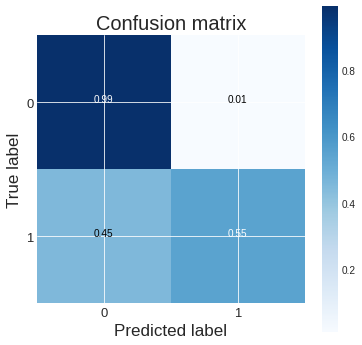

In [45]:
cnf_matrix = confusion_matrix(Test.label.to_list(), y_pred_1d)
plt.figure(figsize = (6,6))
plot_confusion_matrix(cnf_matrix, classes = Test.label.unique(), title = "Confusion matrix")
plt.show()

In [46]:
print(classification_report(list(Test.label), y_pred_1d))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7447
           1       0.81      0.55      0.65       544

    accuracy                           0.96      7991
   macro avg       0.89      0.77      0.82      7991
weighted avg       0.96      0.96      0.96      7991



# Predictions on unseen data

In [47]:
results = pd.DataFrame()

Y_test = pad_sequences(tokenizer.texts_to_sequences(test.tweet), maxlen = MAX_LENGTH)


final_scores = model.predict(Y_test, verbose = 1, batch_size = 10000)
y_pred_1d = [decode_sentiment(score) for score in final_scores]

results['id'] = test['id'].tolist()
results['label'] = y_pred_1d
results.to_csv('tweets_v1.csv', index = False)
results.head()

2/2 [==============================] - 0s 102ms/step


,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


# BERT Model

##### Bert large uncased

- 24-layer, 1024-hidden, 16-heads, 340M parameters
- Trained on lower-cased English text

In [48]:
import tensorflow as tf
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


- **max_len**: Maximum sequence size for BERT is 512
- **batch_encode_plus**: It will generate a dictionary which contains the input_ids, token_type_ids and the attention_mask as list for each input sentence

In [49]:
# Maximum sequence size for BERT is 512

def regular_encode(texts, tokenizer, maxlen = 512):
    enc_di = tokenizer.batch_encode_plus(texts, return_attention_masks = False, return_token_type_ids = False, pad_to_max_length = True, max_length = maxlen)
    return np.array(enc_di['input_ids'])

In [50]:
#bert large uncased pretrained tokenizer

tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

# Splitting the data into Train an Test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'], train_data['label'], random_state = 22, test_size = 0.1)

In [52]:
#tokenizing the tweets' descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical

Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen = 128)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 2, dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen = 128)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 2, dtype = 'int32')

In [53]:
def build_model(transformer, loss = 'categorical_crossentropy', max_len = 512):
    input_word_ids = tf.keras.layers.Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]

    #adding dropout layer
    x = tf.keras.layers.Dropout(0.40)(cls_token)

    #using a dense layer of 2 neurons as the number of unique categories is 2. 
    out = tf.keras.layers.Dense(2, activation = 'softmax')(x)

    model = tf.keras.Model(inputs = input_word_ids, outputs = out)
    model.compile(tf.keras.optimizers.Adam(lr = 3e-5), loss = loss, metrics = ['accuracy'])
    return model

In [54]:
#building the model on tpu

with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len = 128)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 1024), (None 335141888 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________


In [55]:
#creating the training and testing dataset.

BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (tf.data.Dataset.from_tensor_slices((Xtrain_encoded, ytrain_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))
test_dataset = (tf.data.Dataset.from_tensor_slices(Xtest_encoded).batch(BATCH_SIZE))

In [56]:
#training for 10 epochs

n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch = n_steps, epochs = 20)

Epoch 1/20
112/112 [==============================] - 48s 432ms/step - accuracy: 0.9173 - loss: 0.3084
Epoch 2/20
112/112 [==============================] - 49s 433ms/step - accuracy: 0.9301 - loss: 0.2728
Epoch 3/20
112/112 [==============================] - 48s 433ms/step - accuracy: 0.9404 - loss: 0.1792
Epoch 4/20
112/112 [==============================] - 49s 434ms/step - accuracy: 0.9641 - loss: 0.1046
Epoch 5/20
112/112 [==============================] - 49s 434ms/step - accuracy: 0.9775 - loss: 0.0662
Epoch 6/20
112/112 [==============================] - 49s 435ms/step - accuracy: 0.9892 - loss: 0.0342
Epoch 7/20
112/112 [==============================] - 49s 434ms/step - accuracy: 0.9929 - loss: 0.0232
Epoch 8/20
112/112 [==============================] - 49s 434ms/step - accuracy: 0.9956 - loss: 0.0130
Epoch 9/20
112/112 [==============================] - 49s 433ms/step - accuracy: 0.9963 - loss: 0.0105
Epoch 10/20
112/112 [==============================] - 49s 434ms/step - a

In [57]:
#making predictions 

preds = model.predict(test_dataset, verbose = 1)

#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

13/13 [==============================] - 13s 976ms/step


In [58]:
Test = test['tweet']
TestEncoded = regular_encode(Test.astype('str'), tokenizer, maxlen = 128)
TestDataset = (tf.data.Dataset.from_tensor_slices(TestEncoded).batch(BATCH_SIZE))

#making predictions
Preds = model.predict(TestDataset, verbose = 1)

#converting the one hot vector output to a linear numpy array.
predClasses = np.argmax(Preds, axis = 1)
predClasses

68/68 [==============================] - 17s 256ms/step


array([0, 1, 0, ..., 0, 0, 0])

# Final Submission

In [59]:
results = pd.DataFrame()

results['id'] = test['id'].tolist()
results['label'] = predClasses
results.to_csv('tweets_BERT_v4.csv', index = False)
results.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
